In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.vector import dynamicsymbols
from sympy import symbols, cos, sin, diff, sqrt, init_printing, latex, Symbol, Eq, solve, lambdify
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

# Make printouts look nicer
latexReplaceRules = {
    r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}
def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr
init_printing(latex_printer=latexNew)

In [ ]:
#can do constants w symbols. w variables, do dynamic symbols

#constants 
G, M, omega, me, ma, f, mu, a, tau = symbols(r"G, M_s, \Omega, m_e, m_a, f, \mu, a, \tau", real=True)

t=Symbol('t')

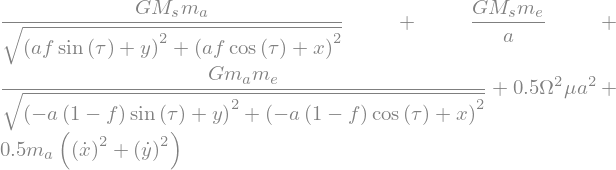

In [ ]:
#degrees of freedom

x, y = dynamicsymbols("x, y", real=True) #add r if need to add slash
x_dot=x.diff()
y_dot=y.diff()

L= 0.5*ma*(x_dot**2+y_dot**2) + 0.5*mu*a**2 *omega**2 + G *M*me/a + G*M*ma/sqrt((x+(f*a*cos(omega*t)))**2+(y+f*a*sin(omega*t))**2)+ G*me*ma/sqrt((x-((1-f)*a*cos(omega*t)))**2+(y-(1-f)*a*sin(omega*t))**2)

L=L.subs(omega*t, tau) #this is the nondimensionalization step w/ tau=t*omega 
L

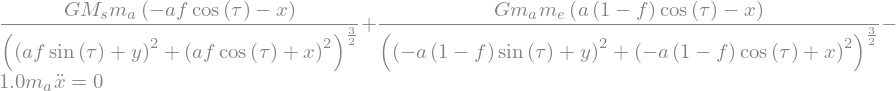

In [5]:
x_derivative = L.diff(x)
x_dot_derivative = L.diff(x_dot)
x_dot_second_derivative = x_dot_derivative.diff(t)

# Euler-Lagrange Equation for x 
ELx = Eq(x_derivative- x_dot_second_derivative, 0)
ELx

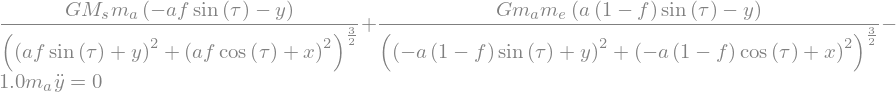

In [6]:
y_derivative = L.diff(y)
y_dot_derivative = L.diff(y_dot)
y_dot_second_derivative = y_dot_derivative.diff(t)

# Euler-Lagrange Equation for y
ELy = Eq(y_derivative- y_dot_second_derivative, 0)

ELy

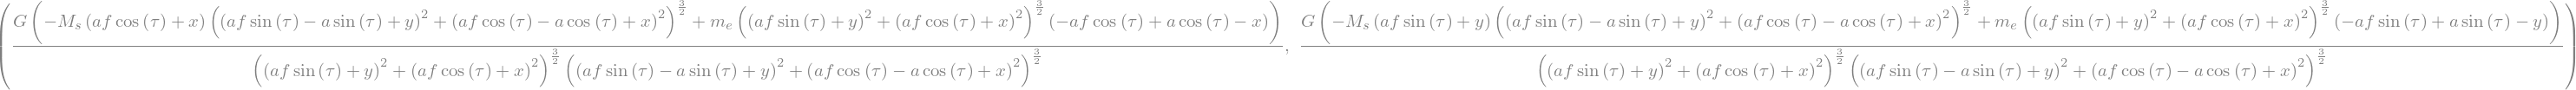

In [7]:
# Isolating x & y double dot

x_doubledot= solve(ELx, x_dot.diff(t))[0] 
y_doubledot= solve(ELy, y_dot.diff(t))[0] #[0] to turn to not list, since gives list of solutions, but there's only 1 solution

x_doubledot, y_doubledot

In [8]:
# lambdify, give eq in terms of variables, gives its inputs, then lets you input the inputs in the expression. So turn symbolic math into python function 

ELsubs = {
    mu: me*M/(M+me),
    f: me/(M+me),
}
gx = lambdify((tau, x, y, ma, M, me, G, a), x_doubledot.subs(ELsubs), 'numpy') # can't print, is function
fy = lambdify([tau, x, y, ma, M, me, G, a], y_doubledot.subs(ELsubs), 'numpy')

def three_body_prob(tau, Y, me, M, ma, G, a):
    x, w, y, z = Y #separates Y into 4 variables

    x_dot = w
    y_dot = z
    w_dot = gx(tau, x, y, ma, M, me, G, a)
    z_dot = fy(tau, x, y, ma, M, me, G, a)

    return x_dot, w_dot, y_dot, z_dot

In [9]:
#solving the differential equation

#t_eval=t does more intermediate positions

t_eval = np.linspace(0, 300, 1000) #a range, specifies gaps between numbers. linspace gives start, end, jump

### Useful ICs ###
# Orbits around sun, close
# initial_conditions= [100, 0, 0, 100] #x initial, y initial, x dot initial, y dot initial
# args = (0.1, 1000, 10, 1000, 1000) # ma, M, me, G, a
# Orbits around the sun, same radius as earth
# initial_conditions= [1001, 0, 0, 100] #x initial, y initial, x dot initial, y dot initial
# args = (1, 1e4, 1e2, 1000, 1000) # ma, M, me, G, a
# Interesting ellipical orbit
initial_conditions= [1000.001, 0, 0, 100] #x initial, y initial, x dot initial, y dot initial
args = (1, 1e5, 1e3, 1000, 1000) # ma, M, me, G, a

sol = solve_ivp(three_body_prob, (np.min(t_eval), np.max(t_eval)), initial_conditions, args=args, t_eval=t_eval) #in the same order as defined above. Just returns the times you ask for
xa, wa, ya, za = sol.y
t_eval = sol.t
if sol.status != 0: print("Ran into error solving")

f_sub = ELsubs[f].subs([(M, args[1]), (me, args[2])]).evalf()
a_sub = args[4]

xs = -f_sub * a_sub * np.cos(t_eval)
ys = -f_sub * a_sub * np.sin(t_eval)

xe = (1-f_sub) * a_sub * np.cos(t_eval)
ye = (1-f_sub) * a_sub * np.sin(t_eval)

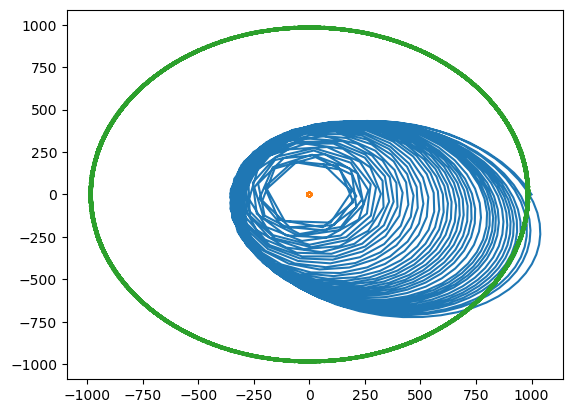

In [10]:
plt.plot(xa, ya)
plt.plot(xs, ys)
plt.plot(xe, ye)

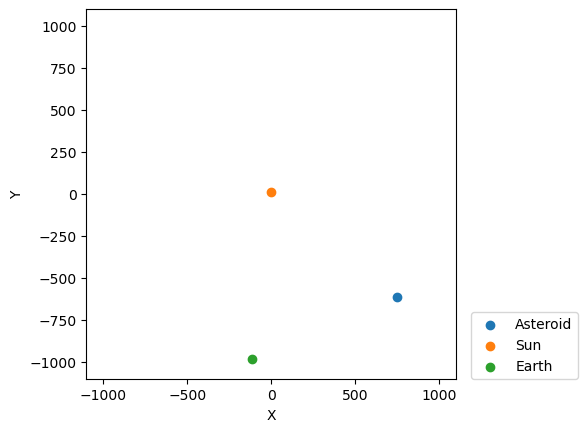

In [11]:
fig, ax = plt.subplots()

# asteroid_line, = ax.plot(xa[0], ya[0], label="Asteroid")
asteroid_line = ax.scatter(xa[0], ya[0], label="Asteroid")
sun_line = ax.scatter(xs[0], ys[0], label="Sun")
earth_line = ax.scatter(xe[0], ye[0], label="Earth")

axis_lim = args[4] * 1.1

ax.set(xlim=[-axis_lim, axis_lim], ylim=[-axis_lim, axis_lim], xlabel='X', ylabel='Y')
ax.set_aspect("equal")
plt.legend(loc=(1.04, 0))

def update(frame):
    # for each frame, update the data stored on each artist.
    # asteroid_line.set_data(xa[:frame], ya[:frame])
    asteroid_line.set_offsets(np.stack([xa[frame], ya[frame]]).T)
    sun_line.set_offsets(np.stack([xs[frame], ys[frame]]).T)
    earth_line.set_offsets(np.stack([xe[frame], ye[frame]]).T)

    return (asteroid_line, sun_line, earth_line)

ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=30, blit=True)#t_eval.shape[0])
# ani.save(filename="example.gif", writer="pillow")
# plt.show()
ani